In [8]:
# --- Imports ---
import yfinance as yf
import pandas as pd
import numpy as np
from pytrends.request import TrendReq
import pandas_ta as ta
from polygon import RESTClient as PolygonClient
from alpha_vantage.fundamentaldata import FundamentalData
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

# Suppress TensorFlow INFO messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

# --- Configuration ---
STOCK_TICKER = "GOOGL"
COMPANY_NAME = "Google"

# -- API Keys (IMPORTANT: Add all your keys here) --
# Get a free key from https://polygon.io/
POLYGON_API_KEY = 'P5KPttsUa4ClukSw_Xqxdfk0SMMVXFXy'
# Get a free key from https://www.alphavantage.co/
ALPHA_VANTAGE_API_KEY = '64NN3MPVW4IE1VXF'

# -- Date Range --
START_DATE = "2020-01-01"
END_DATE = date.today().strftime("%Y-%m-%d")

print("Configuration and libraries are set.")

Configuration and libraries are set.


In [9]:
# --- Step 2: Data Collection ---
print("--- Phase 1: Data Collection ---")

# 1. Price Data for Stock and VIX
raw_price_df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
vix_df = yf.download('^VIX', start=START_DATE, end=END_DATE)

# 2. Google Trends Data (with robust error handling)
print("Fetching Google Trends data...")
try:
    pytrends = TrendReq(hl='en-US', tz=360, timeout=(10, 25), retries=3)
    pytrends.build_payload(kw_list=[COMPANY_NAME], timeframe=f'{START_DATE} {END_DATE}')
    trends_df = pytrends.interest_over_time()
    if trends_df.empty or len(trends_df) < 2: # Check if data is insufficient
        print("Warning: Not enough Google Trends data found. Proceeding without it.")
        raise ValueError("Insufficient Trends Data")
    else:
        print("Google Trends data fetched successfully.")
except Exception as e:
    print(f"WARNING: Could not fetch Google Trends data. Error: {e}")
    print("--> Proceeding without the Google Trends feature.")
    # Create an empty DataFrame with the right index so the subsequent merge doesn't fail
    trends_df = pd.DataFrame(index=raw_price_df.index, columns=[COMPANY_NAME]).fillna(0)

# 3. News Data from Polygon.io
print("Fetching news from Polygon.io...")
try:
    polygon_client = PolygonClient(POLYGON_API_KEY)
    news_articles = []
    # Iterate through pages of news results
    for a in polygon_client.list_ticker_news(STOCK_TICKER, limit=1000, published_utc_gte=START_DATE):
        news_articles.append(a)
    raw_news_df = pd.DataFrame(news_articles)
    print(f"Fetched {len(raw_news_df)} articles from Polygon.io.")
except Exception as e:
    print(f"WARNING: Could not fetch news from Polygon.io: {e}")
    print("--> Proceeding without news features.")
    raw_news_df = pd.DataFrame()

# 4. Fundamental Data (Earnings Per Share)
print("Fetching fundamental (EPS) data...")
try:
    fd = FundamentalData(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
    earnings_data, _ = fd.get_earnings(STOCK_TICKER)
    earnings_data['reportedEPS'] = pd.to_numeric(earnings_data['reportedEPS'], errors='coerce')
    earnings_df = earnings_data[['fiscalDateEnding', 'reportedEPS']].copy()
    earnings_df.dropna(inplace=True)
    print("Fundamental data fetched successfully.")
except Exception as e:
    print(f"WARNING: Could not fetch fundamental data from Alpha Vantage: {e}")
    print("--> Proceeding without the EPS feature.")
    earnings_df = pd.DataFrame()

print("--- Data collection complete. ---")

--- Phase 1: Data Collection ---


C:\Users\vasam\AppData\Local\Temp\ipykernel_41504\2173987741.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_price_df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
C:\Users\vasam\AppData\Local\Temp\ipykernel_41504\2173987741.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_df = yf.download('^VIX', start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


Fetching Google Trends data...
--> Proceeding without the Google Trends feature.
Fetching news from Polygon.io...


C:\Users\vasam\AppData\Local\Temp\ipykernel_41504\2173987741.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trends_df = pd.DataFrame(index=raw_price_df.index, columns=[COMPANY_NAME]).fillna(0)


--> Proceeding without news features.
Fetching fundamental (EPS) data...
--> Proceeding without the EPS feature.
--- Data collection complete. ---


In [10]:
print("\n--- Phase 2: Advanced Feature Engineering ---")
# Start with price data
master_df = raw_price_df.copy()
if isinstance(master_df.columns, pd.MultiIndex):
    master_df.columns = master_df.columns.get_level_values(0)

# Add VIX and Google Trends
master_df['VIX_Close'] = vix_df['Close']
if not trends_df.empty:
    master_df = master_df.join(trends_df[COMPANY_NAME])
    master_df.rename(columns={COMPANY_NAME: 'google_trends'}, inplace=True)

# Add EPS data
if not earnings_df.empty:
    earnings_df.set_index(pd.to_datetime(earnings_df['fiscalDateEnding']), inplace=True)
    eps_daily = earnings_df['reportedEPS'].reindex(master_df.index, method='ffill')
    master_df['EPS'] = eps_daily

# Add technical indicators
master_df.ta.rsi(length=14, append=True)
master_df.ta.macd(append=True)
master_df['returns'] = master_df['Close'].pct_change()

# Add and aggregate news sentiment from Polygon.io
if not raw_news_df.empty:
    raw_news_df['published_utc'] = pd.to_datetime(raw_news_df['published_utc']).dt.date
    # Polygon provides a sentiment score directly
    news_sentiment_df = raw_news_df.groupby('published_utc')['sentiment'].mean().to_frame()
    news_sentiment_df.index = pd.to_datetime(news_sentiment_df.index)
    master_df = master_df.join(news_sentiment_df)
    master_df.rename(columns={'sentiment': 'avg_sentiment'}, inplace=True)

# Final cleanup
master_df.fillna(0, inplace=True)
master_df.dropna(inplace=True)

print("Advanced Feature Engineering complete.")
master_df.info()


--- Phase 2: Advanced Feature Engineering ---
Advanced Feature Engineering complete.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1426 entries, 2020-01-02 to 2025-09-04
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          1426 non-null   float64
 1   High           1426 non-null   float64
 2   Low            1426 non-null   float64
 3   Open           1426 non-null   float64
 4   Volume         1426 non-null   int64  
 5   VIX_Close      1426 non-null   float64
 6   google_trends  1426 non-null   int64  
 7   RSI_14         1426 non-null   float64
 8   MACD_12_26_9   1426 non-null   float64
 9   MACDh_12_26_9  1426 non-null   float64
 10  MACDs_12_26_9  1426 non-null   float64
 11  returns        1426 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 177.1 KB


In [11]:
# --- Step 3: Scaling and Sequencing ---
print("\n--- Phase 3: Final Data Preparation ---")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(master_df)
scaled_df = pd.DataFrame(scaled_data, columns=master_df.columns, index=master_df.index)

SEQUENCE_LENGTH = 60
TARGET_COLUMN_INDEX = scaled_df.columns.get_loc('Close')
X, y = [], []
X_data, y_data = scaled_df.to_numpy(), scaled_df['Close'].to_numpy()

for i in range(SEQUENCE_LENGTH, len(scaled_data)):
    X.append(X_data[i-SEQUENCE_LENGTH:i, :])
    y.append(y_data[i])

X, y = np.array(X), np.array(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Data Splitting
SPLIT_RATIO = 0.8
split_index = int(len(X) * SPLIT_RATIO)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


--- Phase 3: Final Data Preparation ---
X shape: (1366, 60, 12), y shape: (1366,)
X_train shape: (1092, 60, 12), X_test shape: (274, 60, 12)


In [12]:
# --- Step 4: Build the Transformer Model ---
def transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1):
    # Attention and Normalization
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(inputs + x)
    # Feed Forward Part
    ffn = Dense(ff_dim, activation="relu")(x)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    return LayerNormalization(epsilon=1e-6)(x + ffn)

print("Building the Transformer model...")
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = input_layer
# We can stack multiple transformer blocks for a deeper model
for _ in range(2): # Stacking 2 transformer blocks
    x = transformer_encoder(x)

# Final output layers
x = GlobalAveragePooling1D(data_format="channels_last")(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
output_layer = Dense(1)(x)

model_transformer = Model(inputs=input_layer, outputs=output_layer)
model_transformer.compile(optimizer='adam', loss='mean_squared_error')
model_transformer.summary()

Building the Transformer model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 60, 12)]             0         []                            
                                                                                                  
 multi_head_attention_2 (Mu  (None, 60, 12)               52236     ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 dropout_5 (Dropout)         (None, 60, 12)               0         ['multi_head_attention_2[0][0]
                                                                    ']                            
                                                          

In [13]:
# --- Step 5: Train the Transformer Model ---
EPOCHS = 40 # Transformers can sometimes train faster
BATCH_SIZE = 32
print(f"\nTraining the Transformer model for {EPOCHS} epochs...")
history = model_transformer.fit(X_train, y_train,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                validation_data=(X_test, y_test),
                                verbose=1)
print("Model training complete.")


Training the Transformer model for 40 epochs...
Epoch 1/40
35/35 [==============================] - 3s 37ms/step - loss: 0.0483 - val_loss: 0.0648
Epoch 2/40
35/35 [==============================] - 1s 33ms/step - loss: 0.0271 - val_loss: 0.0392
Epoch 3/40
35/35 [==============================] - 1s 32ms/step - loss: 0.0148 - val_loss: 0.0161
Epoch 4/40
35/35 [==============================] - 1s 33ms/step - loss: 0.0095 - val_loss: 0.0128
Epoch 5/40
35/35 [==============================] - 1s 36ms/step - loss: 0.0078 - val_loss: 0.0141
Epoch 6/40
35/35 [==============================] - 1s 36ms/step - loss: 0.0064 - val_loss: 0.0152
Epoch 7/40
35/35 [==============================] - 1s 36ms/step - loss: 0.0054 - val_loss: 0.0157
Epoch 8/40
35/35 [==============================] - 1s 35ms/step - loss: 0.0052 - val_loss: 0.0185
Epoch 9/40
35/35 [==============================] - 1s 35ms/step - loss: 0.0046 - val_loss: 0.0151
Epoch 10/40
35/35 [==============================] - 1s 38ms

Plotting model loss...


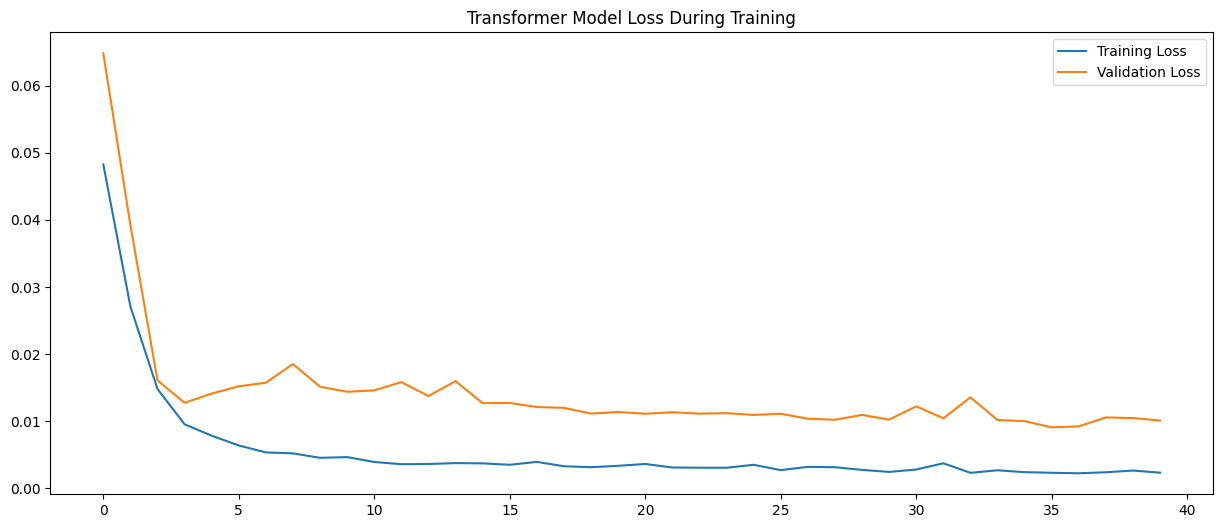


Making predictions...
9/9 [==============================] - 0s 11ms/step

Plotting actual vs. predicted prices...


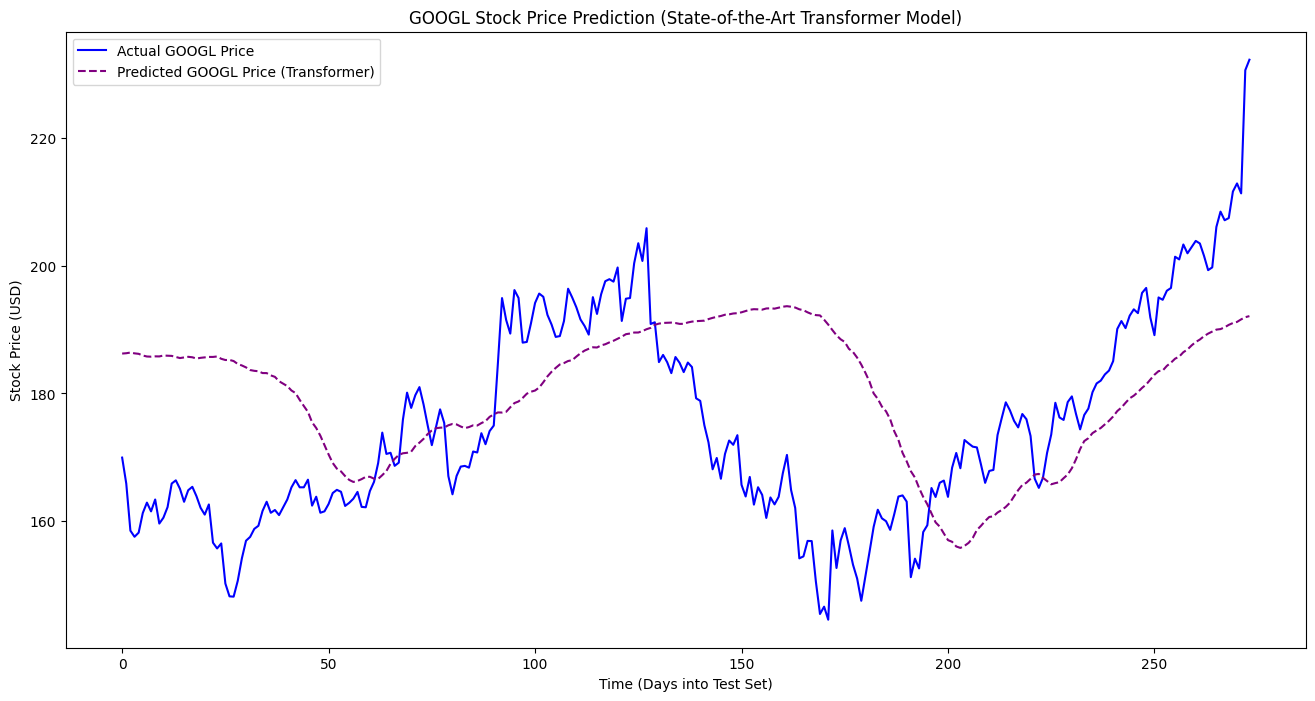

In [14]:
# --- Step 6: Evaluate and Visualize ---
print("Plotting model loss...")
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Loss During Training')
plt.legend()
plt.show()

print("\nMaking predictions...")
predictions_scaled = model_transformer.predict(X_test)

# Inverse transform to get actual dollar values
num_features = X_train.shape[2]
dummy_array = np.zeros((len(predictions_scaled), num_features))
dummy_array[:, TARGET_COLUMN_INDEX] = predictions_scaled.ravel()
predictions = scaler.inverse_transform(dummy_array)[:, TARGET_COLUMN_INDEX]

dummy_y_test = np.zeros((len(y_test), num_features))
dummy_y_test[:, TARGET_COLUMN_INDEX] = y_test.ravel()
actual_prices = scaler.inverse_transform(dummy_y_test)[:, 0]

# Plot the final results
print("\nPlotting actual vs. predicted prices...")
plt.figure(figsize=(16, 8))
plt.plot(actual_prices, color='blue', label=f'Actual {STOCK_TICKER} Price')
plt.plot(predictions, color='purple', linestyle='--', label=f'Predicted {STOCK_TICKER} Price (Transformer)')
plt.title(f'{STOCK_TICKER} Stock Price Prediction (State-of-the-Art Transformer Model)')
plt.xlabel('Time (Days into Test Set)')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

In [16]:
# Get the correct dates for the test set
test_dates = master_df.index[split_index + SEQUENCE_LENGTH:]

# Create and save the DataFrame WITH the date index
pd.DataFrame({
    'Actual': actual_prices, 
    'Predicted_Transformer': predictions
}, index=test_dates).to_csv('predictions_transformer.csv', index=True, index_label='Date')

print("SUCCESS: Transformer predictions saved with date index.")

SUCCESS: Transformer predictions saved with date index.
